<a href="https://colab.research.google.com/github/ryuzuiin/TeachYourselfCS-CN/blob/master/lightgbm_%E6%96%BD%E8%A8%AD%E3%81%AB%E9%96%A2%E3%81%99%E3%82%8B%E3%83%87%E3%83%BC%E3%82%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=4fb2dab1a524aecbb6a61ef1d0d827274c4269f1a91a87222d9fcac6bc117a89
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
current_directory = '/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/903_個人作業_劉/waterlevelforecasting'
os.chdir(current_directory)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import List, Tuple, Dict, Union, Optional, Any
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from csv_column_extractor import CSVColumnExtractor

import lightgbm as lgb


import japanize_matplotlib
import logging
import sys
from google.colab import drive, files


In [13]:

class MLLogger:

    def __init__(self, log_dir='logs', use_drive=True, case_name='default_case',
                 model_name='default_model', experiment_name='default_experiment',
                 log_level=logging.INFO):
      self.log_dir = log_dir
      self.use_drive = use_drive
      self.case_name = case_name
      self.model_name = model_name
      self.experiment_name = experiment_name
      self.log_level = log_level
      self.use_drive = use_drive

      if self.use_drive:
        #check out if google drive
        if not os.path.ismount("/content/drive"):
          drive.mount("/content/drive")

      self.log_dir = log_dir

      #dynamically produce logger filename, including timestamp, case, model and experiments
      timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
      self.log_file = f"{self.log_dir}/{timestamp}_{case_name}_{model_name}_{experiment_name}.log"

      if not os.path.exists(self.log_dir):
        os.makedirs(self.log_dir) # need to be modify

      logger_name = f"{case_name}_{model_name}"
      self.setup_logger(logger_name, log_level, log_file)

    def setup_logger(self, log_level, logger_name, log_file):

      logging.basicConfig(
          level=self.log_level,
          format='%(asctime)s -%(name)s - %(levelname)s - %(message)s',
          datefmt='%Y-%m-%d %H:%M:%S',
          handlers=[
              logging.FileHandler(self.log_file),
              logging.StreamHandler()
          ]
      )
      self.logger = logging.getLogger(self.logger_name)

    def log_data_info(self, df : pd.DataFrame, df_name : Optional[str] = None):
      if df_name is None:
        df_name = 'df'
      self.logger.info(f'df information for {df_name}:')
      self.logger.info(f'shape: {df.shape}')
      self.logger.info(f'columns: {df.columns.tolist()}')
      self.logger.info(f'head: {df.head()}')
      self.logger.info(f'missing values: {df.isnull().sum()}')

      #save discription file
      description_file = f'{self.log_dir}/{df_name}_description.txt'
      with open(description_file, 'w') as f:
        df.info(buf=f)
      self.logger.info(f'description saved to {description_file}')


In [15]:

class MLLogger:
    def __init__(self, log_dir='logs', use_drive=True, case_name='default_case',
                 model_name='default_model', experiment_name='default_experiment',
                 log_level=logging.INFO):
        self.use_drive = use_drive
        self.case_name = case_name
        self.model_name = model_name
        self.experiment_name = experiment_name
        self.log_level = log_level

        if self.use_drive:
            if not os.path.ismount("/content/drive"):
                drive.mount("/content/drive")
            self.log_dir = log_dir
        else:
            self.log_dir = log_dir


        os.makedirs(self.log_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = f"{self.log_dir}/{timestamp}_{case_name}_{model_name}_{experiment_name}.log"

        self.logger_name = f"{case_name}_{model_name}"
        self.setup_logger()

    def setup_logger(self):
        logging.basicConfig(
            level=self.log_level,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S',
            handlers=[
                logging.FileHandler(self.log_file),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(self.logger_name)

    def log_data_info(self, df: pd.DataFrame, df_name: Optional[str] = None):
        if df_name is None:
            df_name = 'df'
        self.logger.info(f'df information for {df_name}:')
        self.logger.info(f'shape: {df.shape}')
        self.logger.info(f'columns: {df.columns.tolist()}')
        self.logger.info(f'head:\n{df.head().to_string()}')
        self.logger.info(f'missing values:\n{df.isnull().sum().to_string()}')

        description_file = f'{self.log_dir}/{df_name}_description.txt'
        with open(description_file, 'w') as f:
            df.info(buf=f)
        self.logger.info(f'description saved to {description_file}')




In [16]:
if __name__ == "__main__":
    log_dir = '/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/903_個人作業_劉/waterlevelforecasting/logs'
    use_drive = True
    case_name = 'experiment_case'
    model_name = 'lightGBM'
    experiment_name = '下流データ_experiment'
    log_level = logging.INFO

    ml_logger = MLLogger(log_dir, use_drive, case_name, model_name, experiment_name, log_level)

    # 测试日志记录
    ml_logger.logger.info("This is a test logger")

In [17]:
# "G:\共有ドライブ\03_2911_内外_農水省_農業用水需要予測_日野川地区\001_授受ファイル\merged_data"

!ls '/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/001_授受ファイル/merged_data'

'anomaly_report for ダム・頭首工取水量2012_2023_unorganized.csv'
'anomaly_report for ダム・頭首工水位／開度2012_2023_unorganized.csv'
'anomaly_report for 分水工・吐出工水位他2012_2023_unorganized.csv'
'anomaly_report for 揚水機場流量・圧力他2012_2023_unorganized.csv'
'anomaly_report for 管網系分水工2012_2023_unorganized.csv'
'anomaly_report for 雨量2012_2023_unorganized.csv'
 anomaly_report.xlsx
 ダム・頭首工取水量2012_2023_unorganized.csv
 ダム・頭首工水位／開度2012_2023_unorganized.csv
 分水工・吐出工水位他2012_2023_unorganized.csv
 揚水機場流量・圧力他2012_2023_unorganized.csv
 管網系分水工2012_2023_unorganized.csv
 雨量2012_2023_unorganized.csv


In [18]:
aaa= pd.read_csv('/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/001_授受ファイル/merged_data/揚水機場流量・圧力他2012_2023_unorganized.csv')
aaa.columns

Index(['Time', '第１段揚水機場(管網系) 送水流量', '第１段揚水機場(管網系) 送水圧力',
       '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系)No2ﾎﾟﾝﾌﾟ回転数',
       '第１段揚水機場(管網系)No3ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系) 使用電流', '第１段揚水機場(多段系) 送水流量',
       '第１段揚水機場(多段系) 送水圧力', '第１段揚水機場(多段系)No1ﾎﾟﾝﾌﾟ回転数',
       '第１段揚水機場(多段系)No2ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系)No3ﾎﾟﾝﾌﾟ回転数',
       '第１段揚水機場(多段系) 使用電流', '第１段揚水機場 調整池水位', '第２段揚水機場 送水流量', '第２段揚水機場 送水圧力',
       '第２段揚水機場 No1ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No2ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No3ﾎﾟﾝﾌﾟ回転数',
       '第２段揚水機場 使用電流', '第２段揚水機場 調整池水位', '第３段揚水機場(３号系) 送水流量',
       '第３段揚水機場(３号系) 送水圧力', '第３段揚水機場(３号系)��1ﾎﾟﾝﾌﾟ回転数',
       '第３段揚水機場(３号系)��2ﾎﾟﾝﾌﾟ回転数', '第３段揚水機場(３号系) 使用電流', '第３段揚水機場 第１調整池水位',
       '第３段揚水機場 第２調整池水位', '第３段揚水機場(野出系) 送水流量', '第３段揚水機場(野出系) 使用電流',
       '第３段揚水機場(蓮花寺系) 送水流量', '第３段揚水機場(蓮花寺系) 使用電流', '尉老溜 水位', 'ｵｺ谷溜 水位',
       '室ヶ谷溜 水位', '第４段揚水機場(４号系) 送水流量', '第４段揚水機場(４号系) 送水圧力',
       '第４段揚水機場(４) ��1ﾎﾟﾝﾌﾟ回転数', '第４段揚水機場(４) ��2ﾎﾟﾝﾌﾟ回転数',
       '第４段揚水機場(４) ﾎﾟﾝﾌﾟ使用合計電流', '第４段揚水機場(奥師・小野系)送水流量', '第４段揚水機場(奥師・小野系)送水圧力',
       '第

In [27]:
directory = '/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/001_授受ファイル/merged_data'
file_column_map = {
    'ダム・頭首工水位／開度2012_2023_unorganized.csv': ['Hour', 'Minute', 'Weekday', 'Month', 'Year', '別所頭首工 右岸取水ｹﾞｰﾄ開度','別所頭首工 河川水位'],
    'ダム・頭首工取水量2012_2023_unorganized.csv': ['別所頭首工 右岸取水量'],
    '分水工・吐出工水位他2012_2023_unorganized.csv': ['別所９号分水工 水槽水位', '別所９号分水工 分水流量','別所９号分水工 ﾊﾞﾙﾌﾞ開度', '別所９号分水工 送水圧力',
                                            '蒲生東部５号分水工 水槽水位', '蒲生東部５号分水工 分水流量', '蒲生東部５号分水工 ﾊﾞﾙﾌﾞ開度', '蒲生東部５号分水工 送水圧力'],
    '揚水機場流量・圧力他2012_2023_unorganized.csv': ['第１段揚水機場(管網系) 送水流量', '第１段揚水機場(管網系) 送水圧力',
       '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系)No2ﾎﾟﾝﾌﾟ回転数',
       '第１段揚水機場(管網系)No3ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系) 使用電流', '第１段揚水機場(多段系) 送水流量',
       '第１段揚水機場(多段系) 送水圧力', '第１段揚水機場(多段系)No1ﾎﾟﾝﾌﾟ回転数',
       '第１段揚水機場(多段系)No2ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系)No3ﾎﾟﾝﾌﾟ回転数',
       '第１段揚水機場(多段系) 使用電流', '第１段揚水機場 調整池水位', '第２段揚水機場 送水流量', '第２段揚水機場 送水圧力',
       '第２段揚水機場 No1ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No2ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No3ﾎﾟﾝﾌﾟ回転数',
       '第２段揚水機場 使用電流', '第２段揚水機場 調整池水位'],
    '雨量2012_2023_unorganized.csv': ['第１段揚水機場 累計雨量', '第２段揚水機場 累計雨量']
}
time_column = 'Time'

extractor = CSVColumnExtractor(directory, file_column_map, time_column)
df = extractor.extract_columns()
df.head()

,Time,Hour,Minute,Weekday,Month,Year,別所頭首工 右岸取水ｹﾞｰﾄ開度,別所頭首工 河川水位,別所頭首工 右岸取水量,別所９号分水工 水槽水位,...,第１段揚水機場 調整池水位,第２段揚水機場 送水流量,第２段揚水機場 送水圧力,第２段揚水機場 No1ﾎﾟﾝﾌﾟ回転数,第２段揚水機場 No2ﾎﾟﾝﾌﾟ回転数,第２段揚水機場 No3ﾎﾟﾝﾌﾟ回転数,第２段揚水機場 使用電流,第２段揚水機場 調整池水位,第１段揚水機場 累計雨量,第２段揚水機場 累計雨量
0,2012-04-01 00:00:00,0.0,0.0,6.0,4.0,2012.0,0.0,0.46,0.0,0.0,...,5.37,0.0,348.0,0.0,0.0,0.0,NaN,4.00,0.0,0.0
1,2012-04-01 00:10:00,0.0,10.0,6.0,4.0,2012.0,0.0,0.45,0.0,0.0,...,5.34,0.0,348.0,0.0,0.0,0.0,NaN,4.00,NaN,NaN
2,2012-04-01 00:15:00,0.0,15.0,6.0,4.0,2012.0,0.0,0.45,0.0,0.0,...,5.33,0.0,348.0,0.0,0.0,0.0,NaN,3.99,NaN,NaN
3,2012-04-01 00:20:00,0.0,20.0,6.0,4.0,2012.0,0.0,0.45,0.0,0.0,...,5.35,0.0,348.0,0.0,0.0,0.0,NaN,4.00,NaN,NaN
4,2012-04-01 00:30:00,0.0,30.0,6.0,4.0,2012.0,0.0,0.45,0.0,0.0,...,5.38,0.0,348.0,0.0,0.0,0.0,NaN,3.99,NaN,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427588 entries, 0 to 427587
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Time                     427587 non-null  datetime64[ns]
 1   Hour                     427584 non-null  float64       
 2   Minute                   427584 non-null  float64       
 3   Weekday                  427584 non-null  float64       
 4   Month                    427584 non-null  float64       
 5   Year                     427584 non-null  float64       
 6   別所頭首工 右岸取水ｹﾞｰﾄ開度         423643 non-null  float64       
 7   別所頭首工 河川水位               423838 non-null  float64       
 8   別所頭首工 右岸取水量              417277 non-null  float64       
 9   別所９号分水工 水槽水位             411250 non-null  float64       
 10  別所９号分水工 分水流量             411241 non-null  float64       
 11  別所９号分水工 ﾊﾞﾙﾌﾞ開度          411251 non-null  float64       
 12  別所９号分水工 送水圧力    

In [31]:
df.describe()

,Time,Hour,Minute,Weekday,Month,Year,別所頭首工 右岸取水ｹﾞｰﾄ開度,別所頭首工 河川水位,別所頭首工 右岸取水量,別所９号分水工 水槽水位,...,第１段揚水機場 調整池水位,第２段揚水機場 送水流量,第２段揚水機場 送水圧力,第２段揚水機場 No1ﾎﾟﾝﾌﾟ回転数,第２段揚水機場 No2ﾎﾟﾝﾌﾟ回転数,第２段揚水機場 No3ﾎﾟﾝﾌﾟ回転数,第２段揚水機場 使用電流,第２段揚水機場 調整池水位,第１段揚水機場 累計雨量,第２段揚水機場 累計雨量
count,427587,427584.000000,427584.00000,427584.000000,427584.000000,427584.000000,423643.000000,423838.000000,417277.000000,411250.000000,...,417705.000000,415148.000000,417915.000000,417921.000000,417922.000000,417922.000000,397953.000000,417922.000000,52698.000000,52698.000000
mean,2017-12-16 20:29:12.275123968,11.500000,26.25000,3.000000,6.453974,2017.465200,0.123553,2.529412,0.277084,1.439037,...,5.076418,0.811482,504.060656,302.690987,289.918454,281.775618,141.147816,4.081951,0.232608,0.213613
min,2012-04-01 00:00:00,0.000000,0.00000,0.000000,3.000000,2012.000000,0.000000,0.440000,0.000000,0.000000,...,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,-32768.000000,0.220000,0.000000,0.000000
25%,2015-03-08 18:05:00,5.750000,13.75000,1.000000,5.000000,2015.000000,0.010000,2.580000,0.000000,0.000000,...,4.960000,0.000000,418.000000,0.000000,0.000000,0.000000,0.000000,4.030000,0.000000,0.000000
50%,2017-09-15 11:50:00,11.500000,25.00000,3.000000,6.000000,2017.000000,0.040000,2.600000,0.160000,1.990000,...,5.110000,0.470000,533.000000,0.000000,0.000000,0.000000,101.000000,4.130000,0.000000,0.000000
75%,2020-09-23 05:55:00,17.250000,41.25000,5.000000,8.000000,2020.000000,0.120000,2.630000,0.460000,2.030000,...,5.270000,1.660000,589.000000,780.000000,790.000000,780.000000,265.000000,4.210000,0.000000,0.000000
max,2095-04-12 05:20:00,23.000000,50.00000,6.000000,9.000000,2023.000000,1.700000,4.000000,1.210000,246.000000,...,6.000000,4.200000,947.000000,870.000000,900.000000,870.000000,749.000000,4.760000,53.000000,51.000000
std,NaN,6.922195,16.72388,2.001573,1.738655,3.440436,0.218977,0.395737,0.295984,0.977714,...,0.343343,0.877290,95.236408,380.744124,383.513076,377.073776,149.601007,0.228649,1.334295,1.232736


# record the first logger about data description

In [34]:

class MLLogger:
    def __init__(self, log_dir='logs', use_drive=True, case_name='default_case',
                 model_name='default_model', experiment_name='default_experiment',
                 log_level=logging.INFO):
        self.use_drive = use_drive
        self.case_name = case_name
        self.model_name = model_name
        self.experiment_name = experiment_name
        self.log_level = log_level

        if self.use_drive:
            if not os.path.ismount("/content/drive"):
                drive.mount("/content/drive")
            self.log_dir = log_dir  # 使用传入的完整路径
        else:
            self.log_dir = log_dir

        # 确保日志目录存在
        try:
            os.makedirs(self.log_dir, exist_ok=True)
            print(f"日志目录已创建或已存在：{self.log_dir}")
        except Exception as e:
            print(f"创建日志目录时出错：{e}")

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = f"{self.log_dir}/{timestamp}_{case_name}_{model_name}_{experiment_name}.log"

        self.logger_name = f"{case_name}_{model_name}"
        self.setup_logger()

    def setup_logger(self):
        try:
            logging.basicConfig(
                level=self.log_level,
                format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                datefmt='%Y-%m-%d %H:%M:%S',
                handlers=[
                    logging.FileHandler(self.log_file, encoding='utf-8'),
                    logging.StreamHandler()
                ]
            )
            self.logger = logging.getLogger(self.logger_name)
            print(f"日志器设置完成，日志文件：{self.log_file}")
        except Exception as e:
            print(f"设置日志器时出错：{e}")

    def log_data_info(self, df: pd.DataFrame, df_name: Optional[str] = None):
        if df_name is None:
            df_name = 'df'
        try:
          info_text = f"""
          df information for {df_name}:
          shape: {df.shape}
          columns: {df.columns.tolist()}
          missing values:
          {df.isnull().sum().to_string()}
          """

          self.logger.info(info_text)
          description_file = f'{self.log_dir}/{df_name}_description.txt'
          with open(description_file, 'w', encoding='utf-8') as f:
            f.write(info_text)
            f.write('\n\nDetailed DtaFrame Info: \n')
            df.info(buf=f)

          self.logger.info(f'description saved to {description_file}')
          print(f"数据描述文件已保存：{description_file}")

        except Exception as e:
            print(f"记录数据信息时出错：{e}")


In [33]:
# 使用示例
if __name__ == "__main__":
    log_dir = '/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/903_個人作業_劉/waterlevelforecasting/logs'
    use_drive = True
    case_name = 'experiment_case'
    model_name = 'lightGBM'
    experiment_name = '下流データ_experiment'
    log_level = logging.INFO

    ml_logger = MLLogger(log_dir, use_drive, case_name, model_name, experiment_name, log_level)

    # 测试日志记录
    ml_logger.logger.info("这是一条测试日志")
    print("测试日志已记录")

    ml_logger.log_data_info(df, '下流データ_df')

日志目录已创建或已存在：/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/903_個人作業_劉/waterlevelforecasting/logs
日志器设置完成，日志文件：/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/903_個人作業_劉/waterlevelforecasting/logs/20240830_063357_experiment_case_lightGBM_下流データ_experiment.log
测试日志已记录
数据描述文件已保存：/content/drive/Shareddrives/03_2911_内外_農水省_農業用水需要予測_日野川地区/903_個人作業_劉/waterlevelforecasting/logs/下流データ_df_description.txt


In [22]:
ml_logger.log_data_info(df, '下流データ_df')

In [ ]:
df_filtered = df[(df['Year'] >= 2021) & (df['Year'] <= 2022)]
df_filtered.shape

(70272, 39)

In [ ]:
from typing import List
def drop_missing_columns(df: pd.DataFrame, threshold: float = 0.1) -> List[str]:
  non_missing_ratios = df.notnull().mean()
  columns_to_keep = non_missing_ratios[non_missing_ratios > (1 - threshold)].index.tolist()

  return columns_to_keep

In [ ]:
columns_to_keep = drop_missing_columns(df_filtered, threshold=0.1)
columns_to_keep

['Time',
 'Hour',
 'Minute',
 'Weekday',
 'Month',
 'Year',
 '別所頭首工 右岸取水ｹﾞｰﾄ開度',
 '別所頭首工 河川水位',
 '別所頭首工 右岸取水量',
 '別所９号分水工 水槽水位',
 '別所９号分水工 分水流量',
 '別所９号分水工 ﾊﾞﾙﾌﾞ開度',
 '別所９号分水工 送水圧力',
 '蒲生東部５号分水工 水槽水位',
 '蒲生東部５号分水工 分水流量',
 '蒲生東部５号分水工 送水圧力',
 '第１段揚水機場(管網系) 送水流量',
 '第１段揚水機場(管網系) 送水圧力',
 '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数',
 '第１段揚水機場(管網系)No2ﾎﾟﾝﾌﾟ回転数',
 '第１段揚水機場(管網系)No3ﾎﾟﾝﾌﾟ回転数',
 '第１段揚水機場(管網系) 使用電流',
 '第１段揚水機場(多段系) 送水流量',
 '第１段揚水機場(多段系) 送水圧力',
 '第１段揚水機場(多段系)No1ﾎﾟﾝﾌﾟ回転数',
 '第１段揚水機場(多段系)No2ﾎﾟﾝﾌﾟ回転数',
 '第１段揚水機場(多段系)No3ﾎﾟﾝﾌﾟ回転数',
 '第１段揚水機場(多段系) 使用電流',
 '第１段揚水機場 調整池水位',
 '第２段揚水機場 送水流量',
 '第２段揚水機場 送水圧力',
 '第２段揚水機場 No1ﾎﾟﾝﾌﾟ回転数',
 '第２段揚水機場 No2ﾎﾟﾝﾌﾟ回転数',
 '第２段揚水機場 No3ﾎﾟﾝﾌﾟ回転数',
 '第２段揚水機場 使用電流',
 '第２段揚水機場 調整池水位']

In [ ]:
df1=df_filtered[columns_to_keep]
df1.shape

(70272, 36)

In [ ]:
    mask = (df1['Minute'] != 15.0) & (df1['Minute'] != 45.0)
    df1 = df1[mask].reset_index(drop=True)
    df1.shape

(52704, 36)

In [ ]:

target = df1['別所頭首工 河川水位']
train = df1.drop(columns=['別所頭首工 河川水位', 'Time'])

split_index = int(len(train) * 0.8)
X_train, X_test = train.iloc[:split_index], train.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]



In [ ]:
ml_logger = MLLogger()
ml_logger.log_dataset_info(X_train, y_train, X_test, y_test)

2024-08-29 07:25:35,036 - INFO - Train set shape: X - (42163, 34), y - (42163,)
2024-08-29 07:25:35,036 - INFO - Train set shape: X - (42163, 34), y - (42163,)
2024-08-29 07:25:35,036 - INFO - Train set shape: X - (42163, 34), y - (42163,)


INFO:ml_process:Train set shape: X - (42163, 34), y - (42163,)


2024-08-29 07:25:35,052 - INFO - Test set shape: X - (10541, 34), y - (10541,)
2024-08-29 07:25:35,052 - INFO - Test set shape: X - (10541, 34), y - (10541,)
2024-08-29 07:25:35,052 - INFO - Test set shape: X - (10541, 34), y - (10541,)


INFO:ml_process:Test set shape: X - (10541, 34), y - (10541,)


2024-08-29 07:25:35,057 - INFO - Features: ['Hour', 'Minute', 'Weekday', 'Month', 'Year', '別所頭首工 右岸取水ｹﾞｰﾄ開度', '別所頭首工 右岸取水量', '別所９号分水工 水槽水位', '別所９号分水工 分水流量', '別所９号分水工 ﾊﾞﾙﾌﾞ開度', '別所９号分水工 送水圧力', '蒲生東部５号分水工 水槽水位', '蒲生東部５号分水工 分水流量', '蒲生東部５号分水工 送水圧力', '第１段揚水機場(管網系) 送水流量', '第１段揚水機場(管網系) 送水圧力', '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系)No2ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系)No3ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系) 使用電流', '第１段揚水機場(多段系) 送水流量', '第１段揚水機場(多段系) 送水圧力', '第１段揚水機場(多段系)No1ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系)No2ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系)No3ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系) 使用電流', '第１段揚水機場 調整池水位', '第２段揚水機場 送水流量', '第２段揚水機場 送水圧力', '第２段揚水機場 No1ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No2ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No3ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 使用電流', '第２段揚水機場 調整池水位']
2024-08-29 07:25:35,057 - INFO - Features: ['Hour', 'Minute', 'Weekday', 'Month', 'Year', '別所頭首工 右岸取水ｹﾞｰﾄ開度', '別所頭首工 右岸取水量', '別所９号分水工 水槽水位', '別所９号分水工 分水流量', '別所９号分水工 ﾊﾞﾙﾌﾞ開度', '別所９号分水工 送水圧力', '蒲生東部５号分水工 水槽水位', '蒲生東部５号分水工 分水流量', '蒲生東部５号分水工 送水圧力', '第１段揚水機場(管網系) 送水流量', '第１段揚水機場(管網系) 送水圧力', '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数', 

INFO:ml_process:Features: ['Hour', 'Minute', 'Weekday', 'Month', 'Year', '別所頭首工 右岸取水ｹﾞｰﾄ開度', '別所頭首工 右岸取水量', '別所９号分水工 水槽水位', '別所９号分水工 分水流量', '別所９号分水工 ﾊﾞﾙﾌﾞ開度', '別所９号分水工 送水圧力', '蒲生東部５号分水工 水槽水位', '蒲生東部５号分水工 分水流量', '蒲生東部５号分水工 送水圧力', '第１段揚水機場(管網系) 送水流量', '第１段揚水機場(管網系) 送水圧力', '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系)No2ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系)No3ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(管網系) 使用電流', '第１段揚水機場(多段系) 送水流量', '第１段揚水機場(多段系) 送水圧力', '第１段揚水機場(多段系)No1ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系)No2ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系)No3ﾎﾟﾝﾌﾟ回転数', '第１段揚水機場(多段系) 使用電流', '第１段揚水機場 調整池水位', '第２段揚水機場 送水流量', '第２段揚水機場 送水圧力', '第２段揚水機場 No1ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No2ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 No3ﾎﾟﾝﾌﾟ回転数', '第２段揚水機場 使用電流', '第２段揚水機場 調整池水位']


In [ ]:
def backfill_missing_values(*datasets):
    filled_datasets = []
    for dataset in datasets:
        if isinstance(dataset, pd.DataFrame):
            filled_dataset = dataset.bfill()
        elif isinstance(dataset, pd.Series):
            filled_dataset = dataset.bfill()
        elif isinstance(dataset, np.ndarray):
            filled_dataset = pd.DataFrame(dataset).bfill().values
        else:
            raise TypeError("Unsupported data type. Please provide pandas DataFrame, Series, or numpy array.")

        filled_datasets.append(filled_dataset)

    return filled_datasets if len(filled_datasets) > 1 else filled_datasets[0]


X_train, X_test, y_train, y_test = backfill_missing_values(X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4435
[LightGBM] [Info] Number of data points in the train set: 42163, number of used features: 34
[LightGBM] [Info] Start training from score 2.564554
MSE: 0.4845692554115729
R^2: -0.15501949234208956


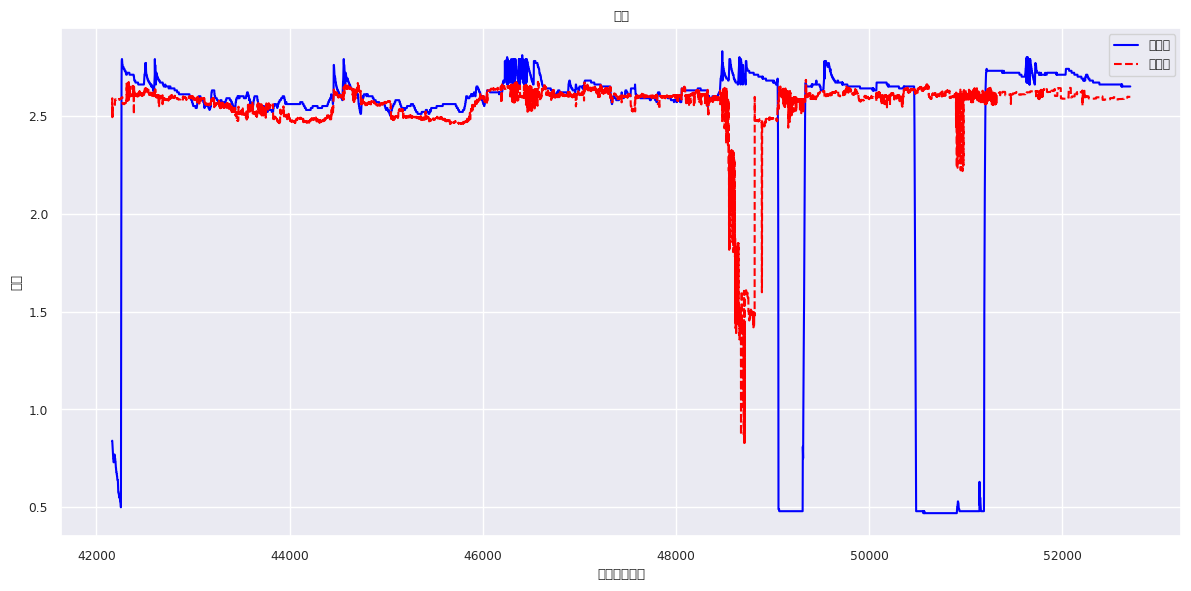

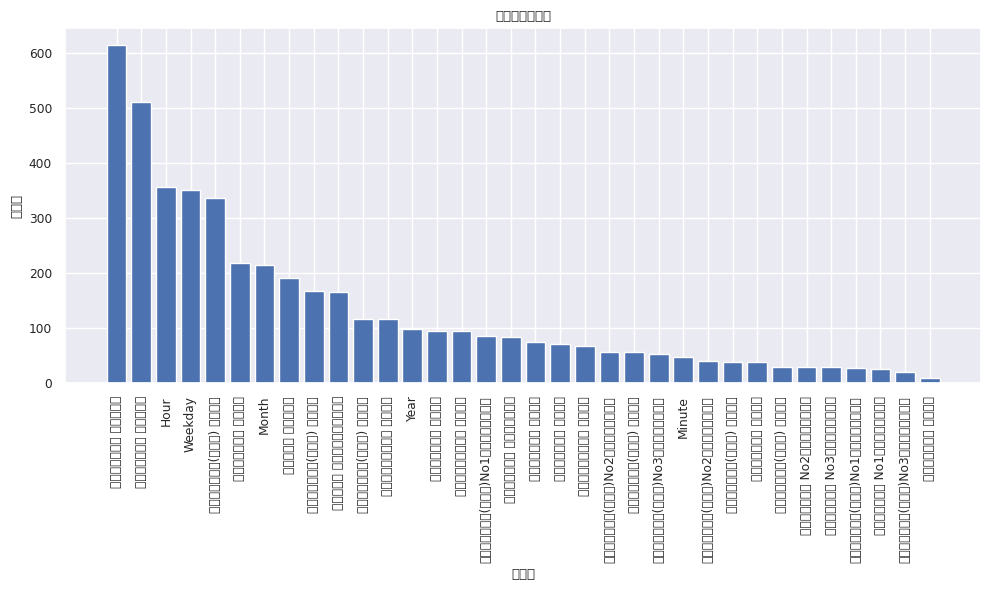

Selected 20 features out of 34

Selected Features:
['第１段揚水機場 調整池水位', '第２段揚水機場 調整池水位', 'Hour', 'Weekday', '第１段揚水機場(管網系) 送水圧力', '別所９号分水工 送水圧力', 'Month', '別所頭首工 右岸取水量', '第１段揚水機場(多段系) 送水圧力', '別所頭首工 右岸取水ｹﾞｰﾄ開度', '第１段揚水機場(管網系) 送水流量', '蒲生東部５号分水工 水槽水位', 'Year', '第２段揚水機場 送水圧力', '蒲生東部５号分水工 送水圧力', '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数', '別所９号分水工 ﾊﾞﾙﾌﾞ開度', '別所９号分水工 水槽水位', '別所９号分水工 分水流量', '蒲生東部５号分水工 分水流量']

Shape of updated X_train: (42163, 20)
Shape of updated X_test: (10541, 20)

Retraining model with selected features...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 42163, number of used features: 20
[LightGBM] [Info] Start training from score 2.564554
MSE: 0.45162653295730254
R^2: -0.07649720447390829


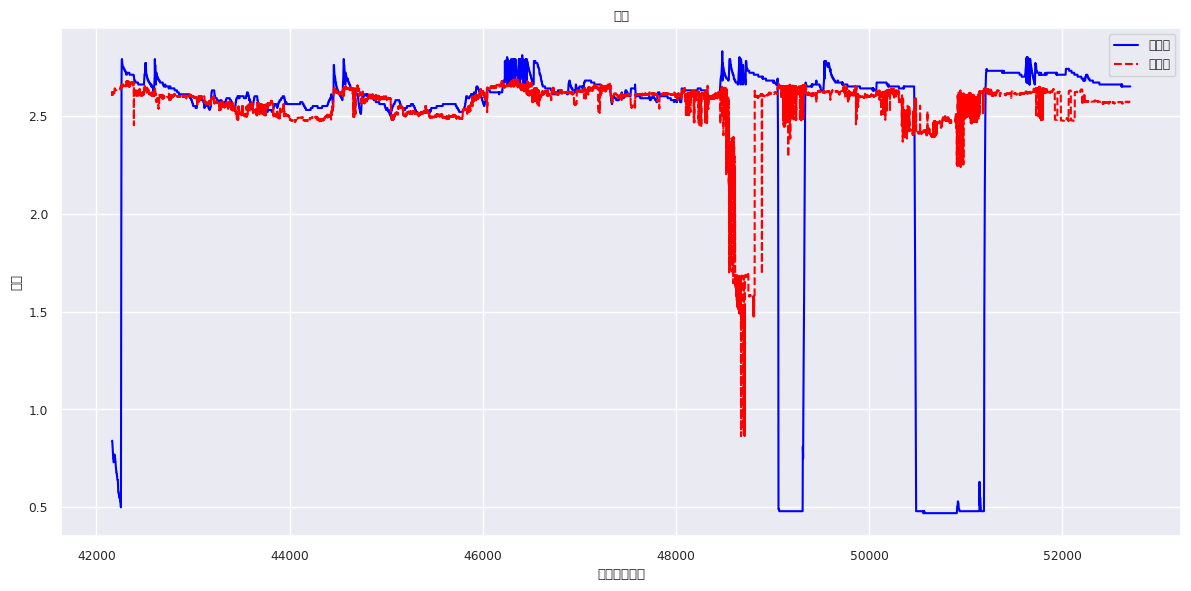

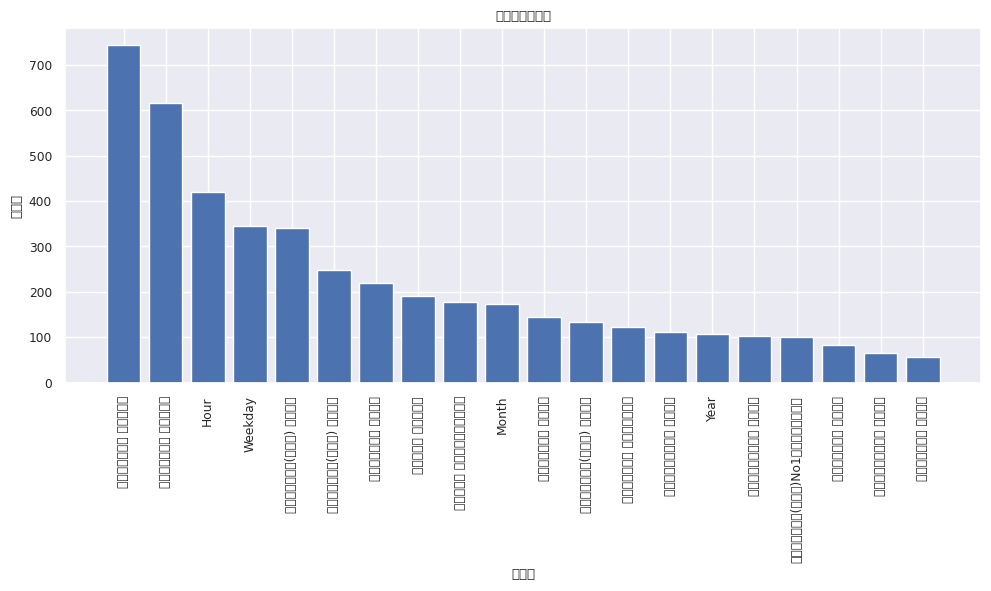


Selected Features:
['第１段揚水機場 調整池水位', '第２段揚水機場 調整池水位', 'Hour', 'Weekday', '第１段揚水機場(管網系) 送水圧力', '別所９号分水工 送水圧力', 'Month', '別所頭首工 右岸取水量', '第１段揚水機場(多段系) 送水圧力', '別所頭首工 右岸取水ｹﾞｰﾄ開度', '第１段揚水機場(管網系) 送水流量', '蒲生東部５号分水工 水槽水位', 'Year', '第２段揚水機場 送水圧力', '蒲生東部５号分水工 送水圧力', '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数', '別所９号分水工 ﾊﾞﾙﾌﾞ開度', '別所９号分水工 水槽水位', '別所９号分水工 分水流量', '蒲生東部５号分水工 分水流量']

Shape of updated X_train: (42163, 20)
Shape of updated X_test: (10541, 20)


In [ ]:
class EnhancedWaterLevelPredictor:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.model = None
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.selected_features = None

    def train_model(self):
        params = {
            'objective': 'regression',
            'metric': 'mse',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9
        }
        train_data = lgb.Dataset(self.X_train, label=self.y_train)
        self.model = lgb.train(params, train_data, num_boost_round=150)

    def make_predictions(self):
        return self.model.predict(self.X_test)

    def evaluate_model(self):
        y_pred = self.make_predictions()
        mse = mean_squared_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)
        print(f"MSE: {mse}")
        print(f"R^2: {r2}")
        return mse, r2

    def plot_results(self):
        y_pred = self.make_predictions()
        plt.figure(figsize=(12, 6))
        plt.plot(self.y_test.index, self.y_test.values, label='実際値', color='blue')
        plt.plot(self.y_test.index, y_pred, label='予測値', color='red', linestyle='--')
        plt.title("水位")
        plt.xlabel('インデックス')
        plt.ylabel('水位')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self):
        feature_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importance()
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        plt.bar(feature_importance['feature'], feature_importance['importance'])
        plt.title("特徴量の重要度")
        plt.xlabel("特徴量")
        plt.ylabel("重要度")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def select_features(self, threshold_method='cumulative', threshold_value=0.9):
        feature_importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importance()
        }).sort_values('importance', ascending=False).reset_index(drop=True)

        if threshold_method == 'cumulative':
            cumulative_importance = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()
            mask = cumulative_importance <= threshold_value
            self.selected_features = feature_importance.loc[mask, 'feature'].tolist()

        elif threshold_method == 'relative':
            mean_importance = feature_importance['importance'].mean()
            mask = feature_importance['importance'] >= (mean_importance * threshold_value)
            self.selected_features = feature_importance.loc[mask, 'feature'].tolist()

        elif threshold_method == 'top_n':
            self.selected_features = feature_importance['feature'].head(int(threshold_value)).tolist()

        else:
            raise ValueError("Invalid threshold_method. Choose 'cumulative', 'relative', or 'top_n'.")

        print(f"Selected {len(self.selected_features)} features out of {len(feature_importance)}")
        return self.selected_features

    def get_selected_features(self):
        if self.selected_features is None:
            raise ValueError("Please run select_features method first.")
        return self.selected_features

    def get_updated_data(self):
        if self.selected_features is None:
            raise ValueError("Please run select_features method first.")
        X_train_selected = self.X_train[self.selected_features]
        X_test_selected = self.X_test[self.selected_features]
        return X_train_selected, X_test_selected

    def run_analysis(self, feature_selection=False, threshold_method='cumulative', threshold_value=0.9):
        self.train_model()
        self.evaluate_model()
        self.plot_results()
        self.plot_feature_importance()

        if feature_selection:
            selected_features = self.select_features(threshold_method, threshold_value)
            X_train_selected, X_test_selected = self.get_updated_data()

            print("\nSelected Features:")
            print(selected_features)

            print("\nShape of updated X_train:", X_train_selected.shape)
            print("Shape of updated X_test:", X_test_selected.shape)

            print("\nRetraining model with selected features...")
            self.X_train = X_train_selected
            self.X_test = X_test_selected
            self.train_model()
            self.evaluate_model()
            self.plot_results()
            self.plot_feature_importance()

if __name__ == "__main__":
    predictor = EnhancedWaterLevelPredictor(X_train, X_test, y_train, y_test)
    predictor.run_analysis(feature_selection=True, threshold_method='cumulative', threshold_value=0.9)

    selected_features = predictor.get_selected_features()
    print("\nSelected Features:")
    print(selected_features)

    X_train_selected, X_test_selected = predictor.get_updated_data()
    print("\nShape of updated X_train:", X_train_selected.shape)
    print("Shape of updated X_test:", X_test_selected.shape)

2024-08-29 07:19:01,191 - INFO - Feature Importance:
2024-08-29 07:19:01,191 - INFO - Feature Importance:


INFO:ml_process:Feature Importance:


2024-08-29 07:19:01,202 - INFO - 
                feature  importance
          第１段揚水機場 調整池水位         744
          第２段揚水機場 調整池水位         616
                   Hour         420
                Weekday         345
      第１段揚水機場(管網系) 送水圧力         340
      第１段揚水機場(多段系) 送水圧力         248
           別所９号分水工 送水圧力         220
            別所頭首工 右岸取水量         191
       別所頭首工 右岸取水ｹﾞｰﾄ開度         177
                  Month         172
           第２段揚水機場 送水圧力         144
      第１段揚水機場(管網系) 送水流量         133
        別所９号分水工 ﾊﾞﾙﾌﾞ開度         123
         蒲生東部５号分水工 水槽水位         112
                   Year         106
         蒲生東部５号分水工 送水圧力         103
第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数         101
           別所９号分水工 水槽水位          83
         蒲生東部５号分水工 分水流量          65
           別所９号分水工 分水流量          57
2024-08-29 07:19:01,202 - INFO - 
                feature  importance
          第１段揚水機場 調整池水位         744
          第２段揚水機場 調整池水位         616
                   Hour         420
                Weekday         

INFO:ml_process:
                feature  importance
          第１段揚水機場 調整池水位         744
          第２段揚水機場 調整池水位         616
                   Hour         420
                Weekday         345
      第１段揚水機場(管網系) 送水圧力         340
      第１段揚水機場(多段系) 送水圧力         248
           別所９号分水工 送水圧力         220
            別所頭首工 右岸取水量         191
       別所頭首工 右岸取水ｹﾞｰﾄ開度         177
                  Month         172
           第２段揚水機場 送水圧力         144
      第１段揚水機場(管網系) 送水流量         133
        別所９号分水工 ﾊﾞﾙﾌﾞ開度         123
         蒲生東部５号分水工 水槽水位         112
                   Year         106
         蒲生東部５号分水工 送水圧力         103
第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数         101
           別所９号分水工 水槽水位          83
         蒲生東部５号分水工 分水流量          65
           別所９号分水工 分水流量          57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2024-08-29 07:19:02,191 - INFO - Feature importance plot saved as 'feature_importance.png'
2024-08-29 07:19:02,191 - INFO - Feature importance plot saved as 'feature_importance.png'


INFO:ml_process:Feature importance plot saved as 'feature_importance.png'


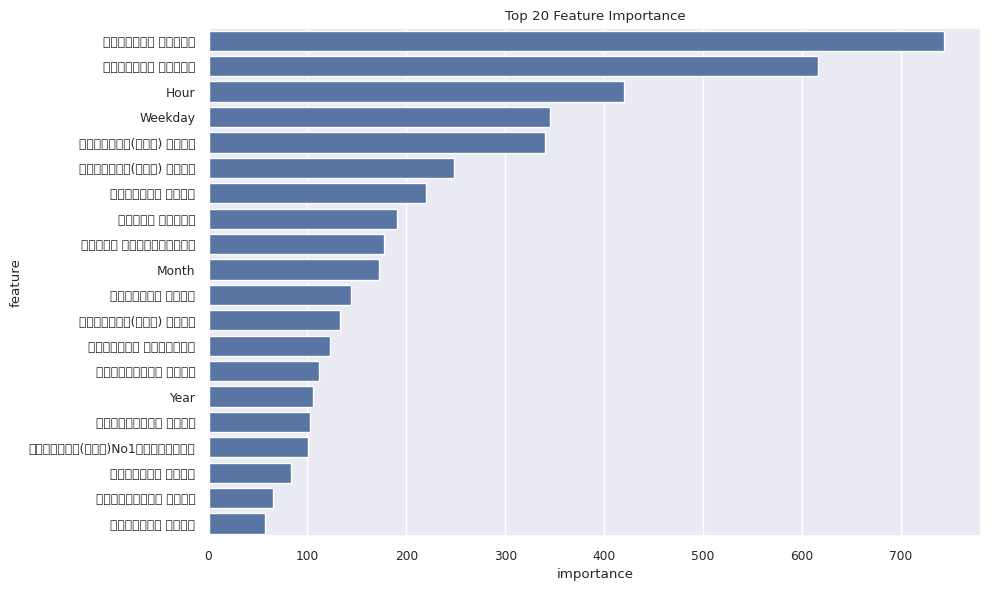

In [ ]:
ml_logger.log_feature_importance(predictor.model, X_train_selected.columns)

In [ ]:
X_train_selected.head()

,第１段揚水機場 調整池水位,第２段揚水機場 調整池水位,Hour,Weekday,第１段揚水機場(管網系) 送水圧力,別所９号分水工 送水圧力,Month,別所頭首工 右岸取水量,第１段揚水機場(多段系) 送水圧力,別所頭首工 右岸取水ｹﾞｰﾄ開度,第１段揚水機場(管網系) 送水流量,蒲生東部５号分水工 水槽水位,Year,第２段揚水機場 送水圧力,蒲生東部５号分水工 送水圧力,第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数,別所９号分水工 ﾊﾞﾙﾌﾞ開度,別所９号分水工 水槽水位,別所９号分水工 分水流量,蒲生東部５号分水工 分水流量
0,5.45,4.09,0.0,3.0,47.0,0.0,4.0,0.10,226.0,0.03,0.0,0.95,2021.0,100.0,9.0,0.0,0.0,1.95,0.0,0.0
1,5.45,4.09,0.0,3.0,47.0,0.0,4.0,0.10,226.0,0.03,0.0,0.95,2021.0,100.0,9.0,0.0,0.0,1.95,0.0,0.0
2,5.45,4.09,0.0,3.0,47.0,0.0,4.0,0.10,226.0,0.03,0.0,0.95,2021.0,99.0,9.0,0.0,0.0,1.95,0.0,0.0
3,5.44,4.09,0.0,3.0,47.0,0.0,4.0,0.09,226.0,0.03,0.0,0.95,2021.0,100.0,9.0,0.0,0.0,1.94,0.0,0.0
4,5.44,4.09,0.0,3.0,47.0,0.0,4.0,0.09,226.0,0.03,0.0,0.95,2021.0,100.0,9.0,0.0,0.0,1.95,0.0,0.0


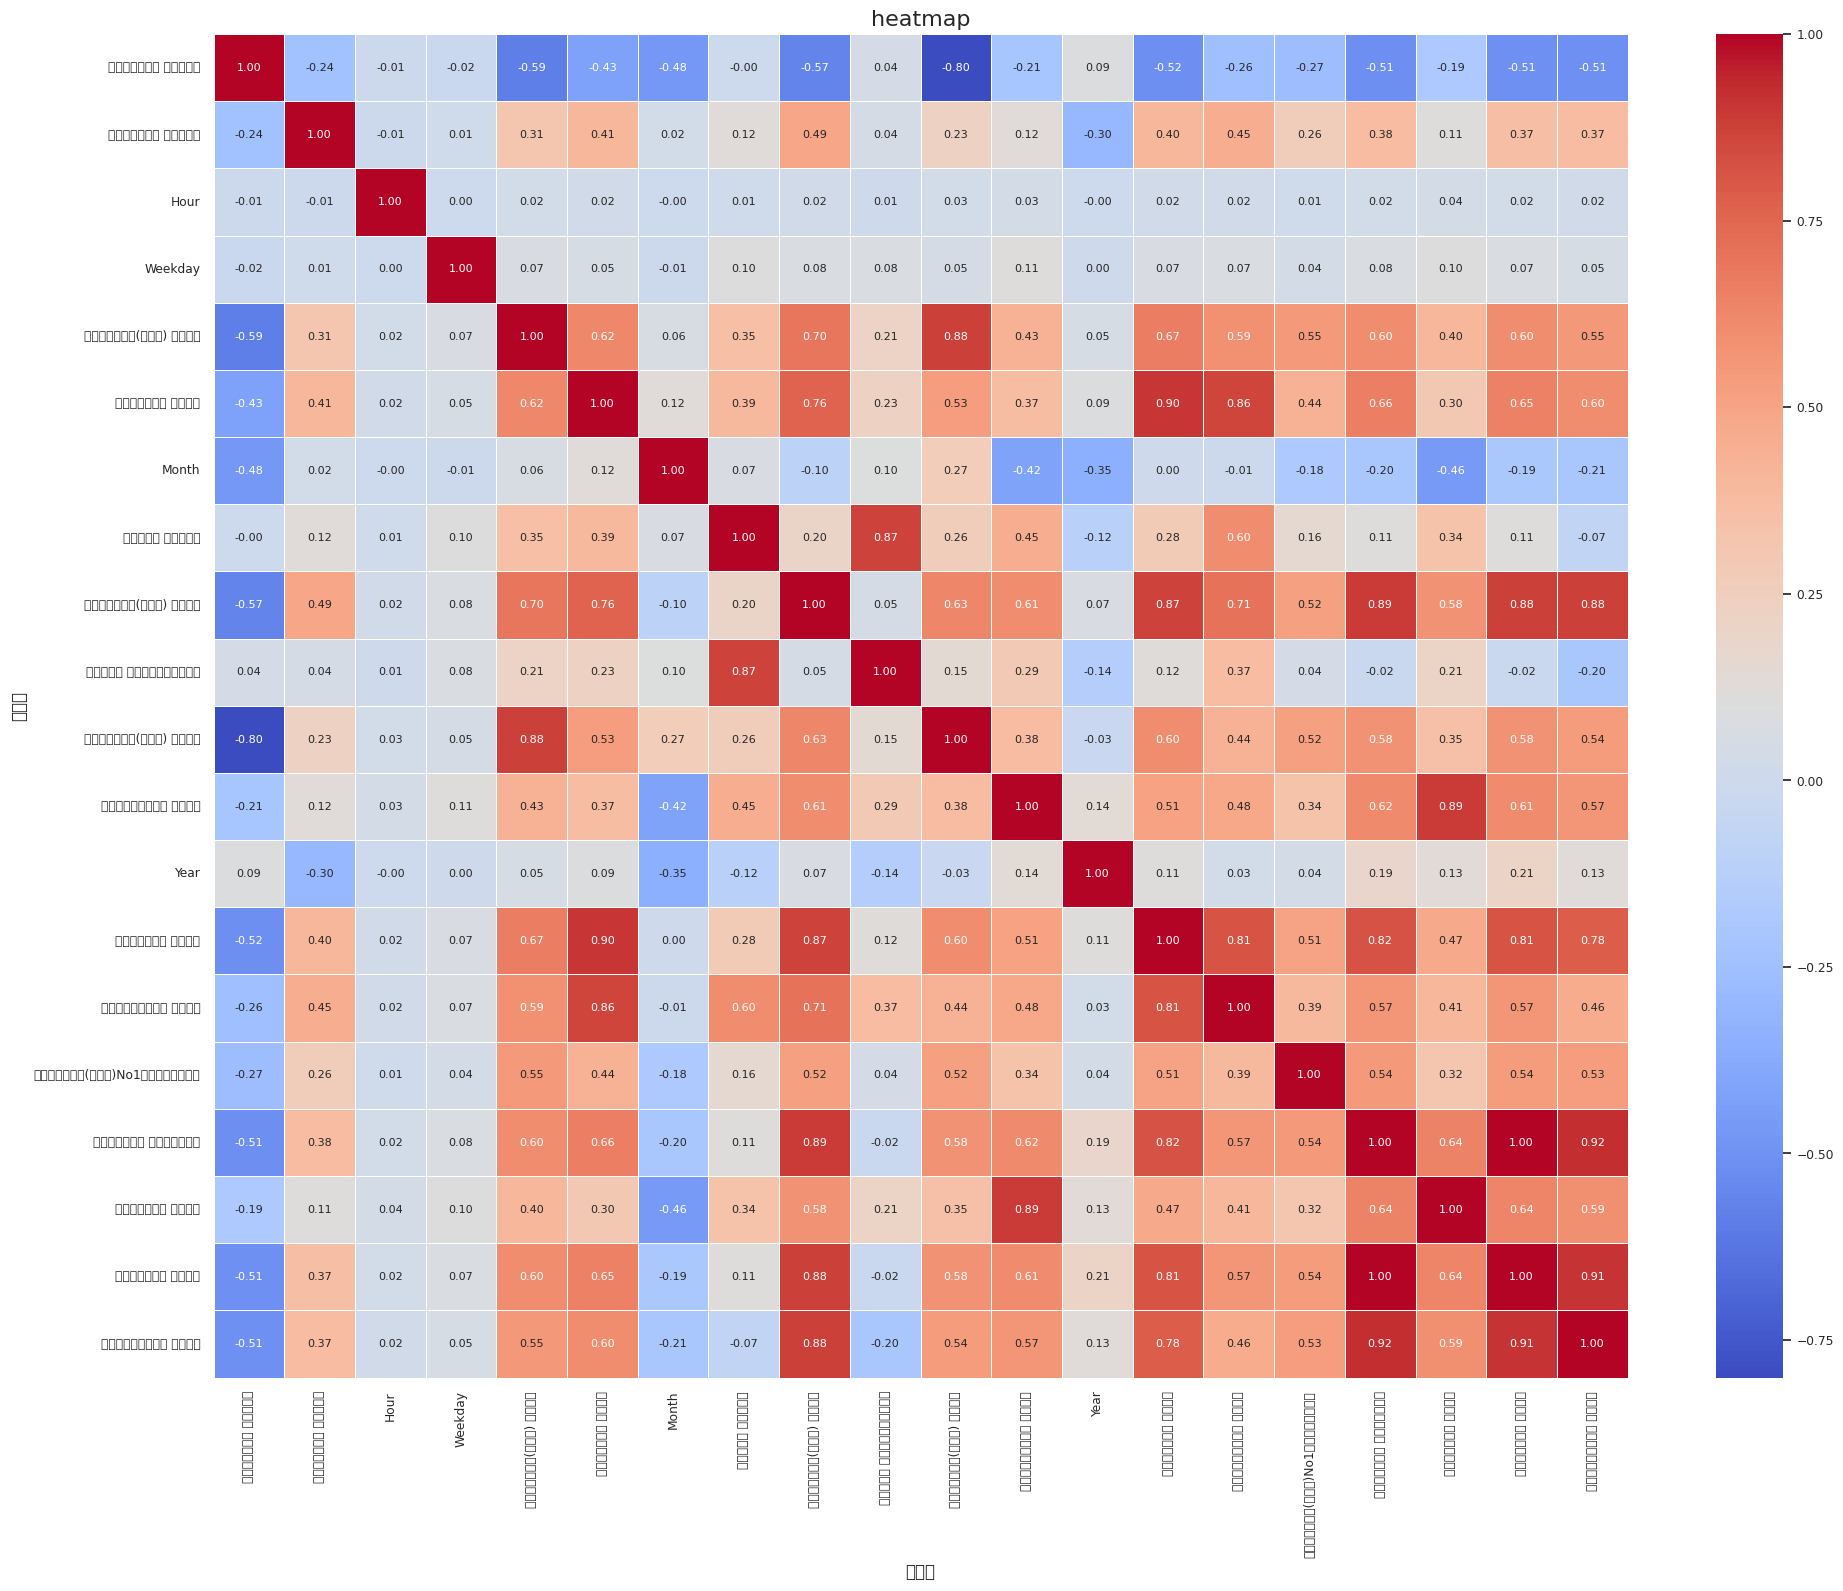

特徴量with corr > 0.9：
第２段揚水機場 送水圧力 - 別所９号分水工 送水圧力: 0.90
別所９号分水工 分水流量 - 別所９号分水工 ﾊﾞﾙﾌﾞ開度: 1.00
蒲生東部５号分水工 分水流量 - 別所９号分水工 ﾊﾞﾙﾌﾞ開度: 0.92
蒲生東部５号分水工 分水流量 - 別所９号分水工 分水流量: 0.91


In [ ]:


def plot_correlation_heatmap(df, figsize=(20, 16), font_scale=0.8, annot_fontsize=8):
    plt.figure(figsize=figsize)
    sns.set(font_scale=font_scale)

    corr_matrix = df.corr()

    heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                          linewidths=0.5, annot_kws={"size": annot_fontsize})


    plt.title("heatmap", fontsize=16)
    plt.xlabel('特徴量', fontsize=12)
    plt.ylabel("特徴量", fontsize=12)


    plt.tight_layout()

    plt.show()

def get_highly_correlated_features(df, threshold=0.8):
    """

    """
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    highly_correlated = [(col1, col2) for col1 in upper_tri.columns
                         for col2 in upper_tri.index
                         if upper_tri.loc[col2, col1] > threshold]
    return highly_correlated

if __name__ == "__main__":

    plot_correlation_heatmap(X_train_selected)

    high_corr_features = get_highly_correlated_features(X_train_selected, threshold=0.9)

    print("特徴量with corr > 0.9：")
    for feature1, feature2 in high_corr_features:
        correlation = X_train_selected[feature1].corr(X_train_selected[feature2])
        print(f"{feature1} - {feature2}: {correlation:.2f}")

    features_to_drop = set()
    for feature1, feature2 in high_corr_features:
        features_to_drop.add(feature2)

    X_train_uncorrelated = X_train_selected.drop(columns=list(features_to_drop))
    X_test_uncorrelated = X_test_selected.drop(columns=list(features_to_drop))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2024-08-29 07:26:42,052 - INFO - Correlation heatmap saved as 'correlation_heatmap.png'
2024-08-29 07:26:42,052 - INFO - Correlation heatmap saved as 'correlation_heatmap.png'
2024-08-29 07:26:42,052 - INFO - Correlation heatmap saved as 'correlation_heatmap.png'


INFO:ml_process:Correlation heatmap saved as 'correlation_heatmap.png'


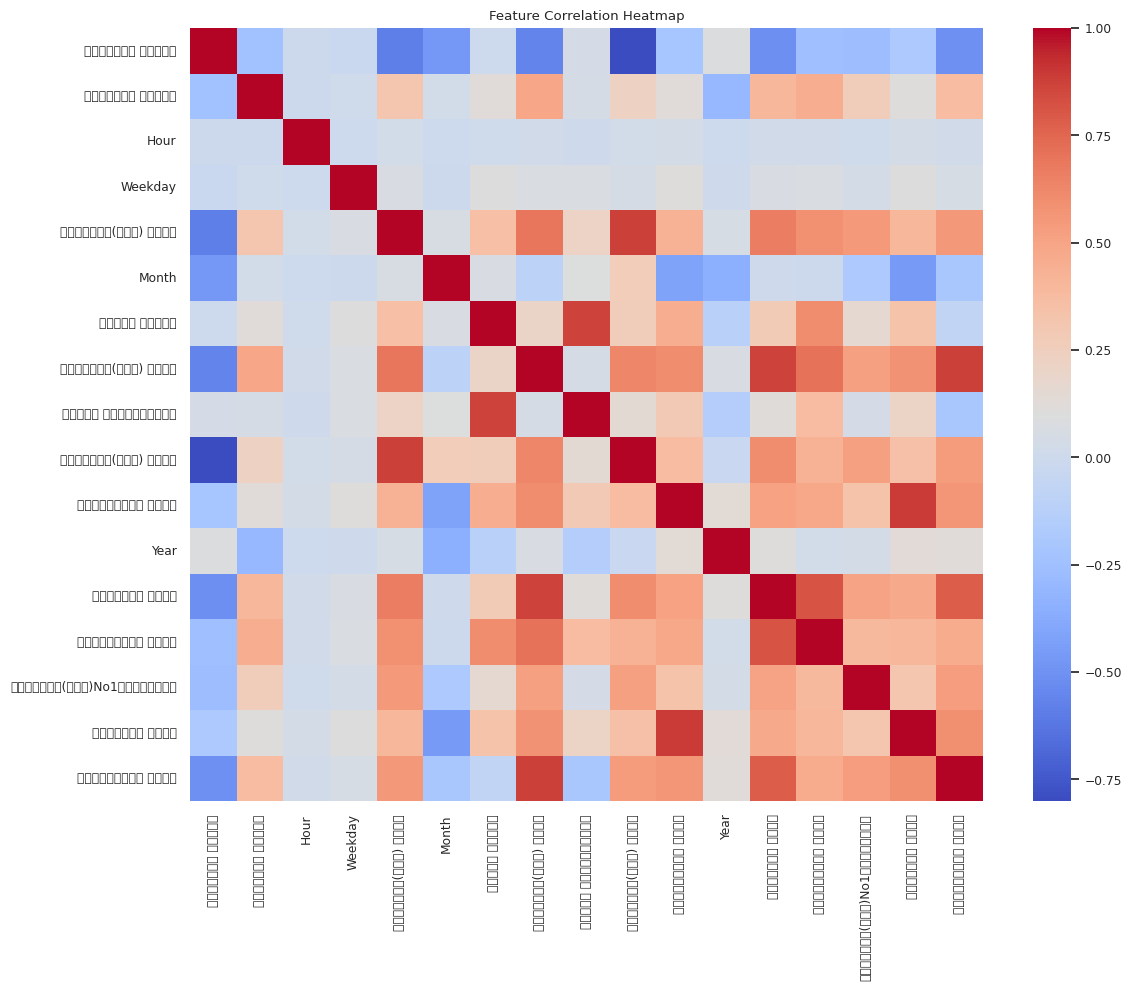

In [ ]:
ml_logger.log_correlation_heatmap(X_train_uncorrelated)

In [ ]:
X_train_uncorrelated.shape, X_test_uncorrelated.shape, y_train.shape, y_test.shape

((42163, 17), (10541, 17), (42163,), (10541,))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 42163, number of used features: 17
[LightGBM] [Info] Start training from score 2.564554
MSE: 0.4716276615864956
R^2: -0.12417190355471952


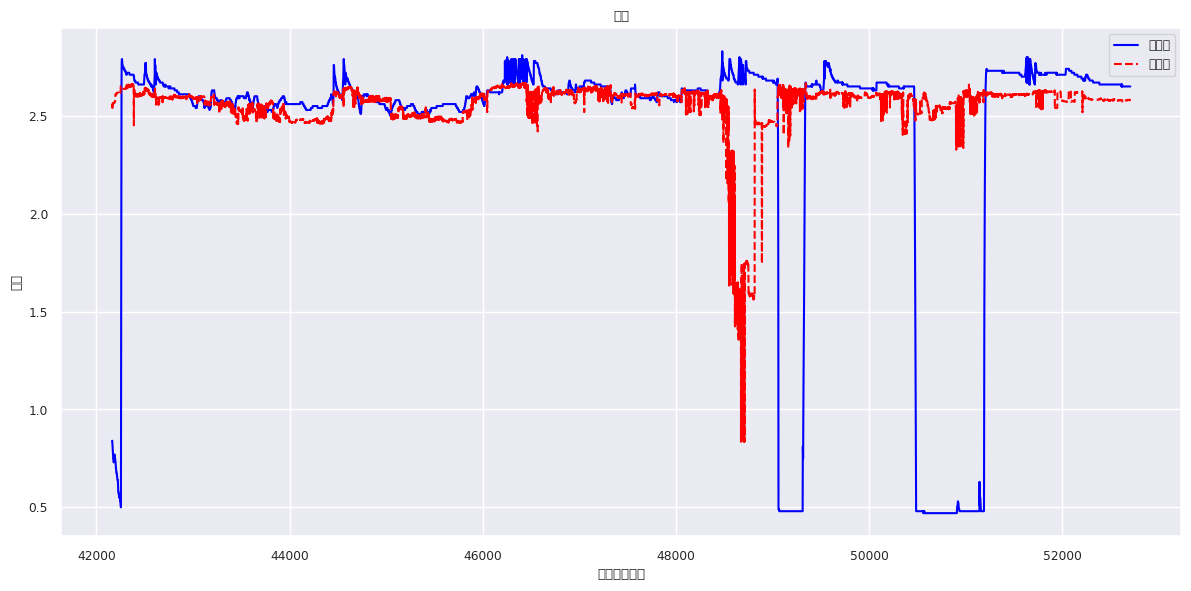

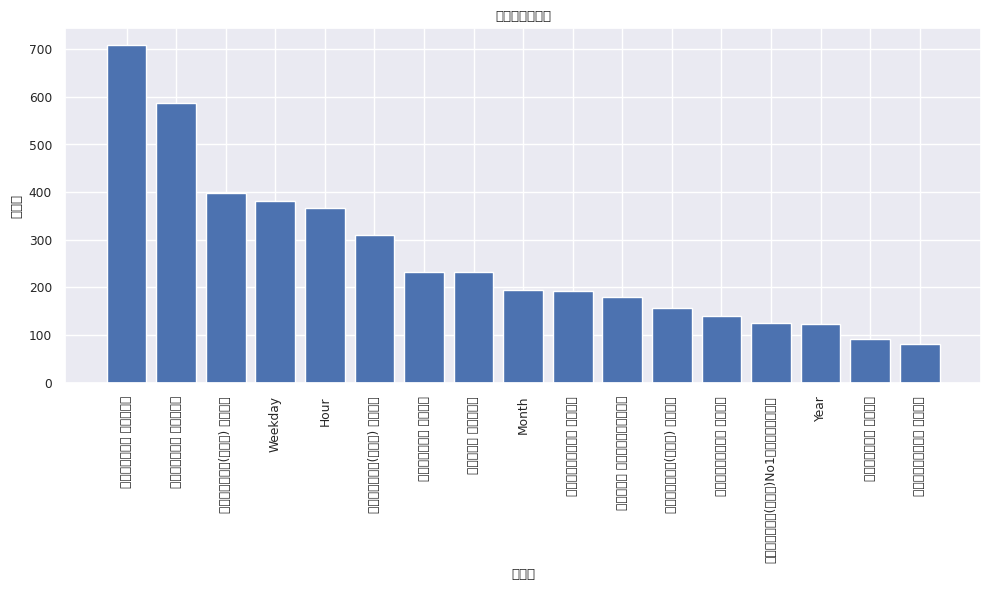

In [ ]:
if __name__ == "__main__":
    predictor = EnhancedWaterLevelPredictor(X_train_uncorrelated, X_test_uncorrelated, y_train, y_test)
    predictor.run_analysis(feature_selection=False, threshold_method='cumulative', threshold_value=0.9)

In [ ]:
X_train_uncorrelated.columns

Index(['第１段揚水機場 調整池水位', '第２段揚水機場 調整池水位', 'Hour', 'Weekday',
       '第１段揚水機場(管網系) 送水圧力', 'Month', '別所頭首工 右岸取水量', '第１段揚水機場(多段系) 送水圧力',
       '別所頭首工 右岸取水ｹﾞｰﾄ開度', '第１段揚水機場(管網系) 送水流量', '蒲生東部５号分水工 水槽水位', 'Year',
       '第２段揚水機場 送水圧力', '蒲生東部５号分水工 送水圧力', '第１段揚水機場(管網系)No1ﾎﾟﾝﾌﾟ回転数',
       '別所９号分水工 水槽水位', '蒲生東部５号分水工 分水流量'],
      dtype='object')

In [ ]:
if __name__ == "__main__":


    high_corr_features = get_highly_correlated_features(X_train_selected, threshold=0.8)

    print("特徴量with corr > 0.8：")
    for feature1, feature2 in high_corr_features:
        correlation = X_train_selected[feature1].corr(X_train_selected[feature2])
        print(f"{feature1} - {feature2}: {correlation:.2f}")

    features_to_drop = set()
    for feature1, feature2 in high_corr_features:
        features_to_drop.add(feature2)

    X_train_uncorrelated2 = X_train_selected.drop(columns=list(features_to_drop))
    X_test_uncorrelated2 = X_test_selected.drop(columns=list(features_to_drop))

特徴量with corr > 0.8：
別所頭首工 右岸取水ｹﾞｰﾄ開度 - 別所頭首工 右岸取水量: 0.87
第１段揚水機場(管網系) 送水流量 - 第１段揚水機場 調整池水位: -0.80
第１段揚水機場(管網系) 送水流量 - 第１段揚水機場(管網系) 送水圧力: 0.88
第２段揚水機場 送水圧力 - 別所９号分水工 送水圧力: 0.90
第２段揚水機場 送水圧力 - 第１段揚水機場(多段系) 送水圧力: 0.87
蒲生東部５号分水工 送水圧力 - 別所９号分水工 送水圧力: 0.86
蒲生東部５号分水工 送水圧力 - 第２段揚水機場 送水圧力: 0.81
別所９号分水工 ﾊﾞﾙﾌﾞ開度 - 第１段揚水機場(多段系) 送水圧力: 0.89
別所９号分水工 ﾊﾞﾙﾌﾞ開度 - 第２段揚水機場 送水圧力: 0.82
別所９号分水工 水槽水位 - 蒲生東部５号分水工 水槽水位: 0.89
別所９号分水工 分水流量 - 第１段揚水機場(多段系) 送水圧力: 0.88
別所９号分水工 分水流量 - 第２段揚水機場 送水圧力: 0.81
別所９号分水工 分水流量 - 別所９号分水工 ﾊﾞﾙﾌﾞ開度: 1.00
蒲生東部５号分水工 分水流量 - 第１段揚水機場(多段系) 送水圧力: 0.88
蒲生東部５号分水工 分水流量 - 別所９号分水工 ﾊﾞﾙﾌﾞ開度: 0.92
蒲生東部５号分水工 分水流量 - 別所９号分水工 分水流量: 0.91


In [ ]:
X_train_uncorrelated2.shape, X_test_uncorrelated2.shape, y_train.shape, y_test.shape

((42163, 11), (10541, 11), (42163,), (10541,))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 42163, number of used features: 11
[LightGBM] [Info] Start training from score 2.564554
MSE: 0.5421799844102521
R^2: -0.29234045156182886


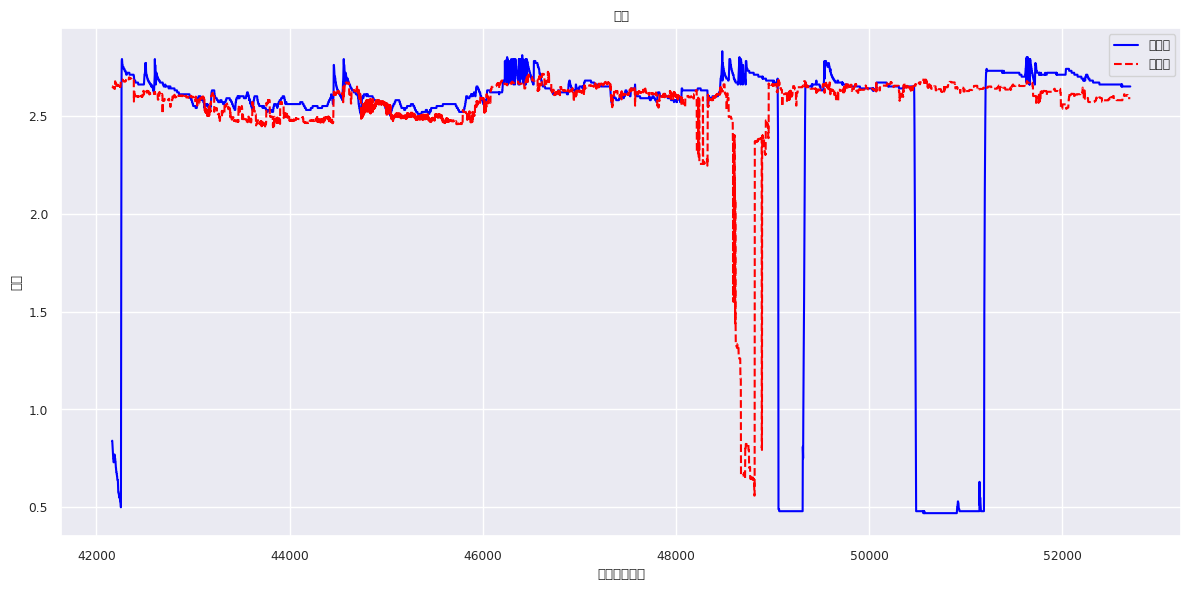

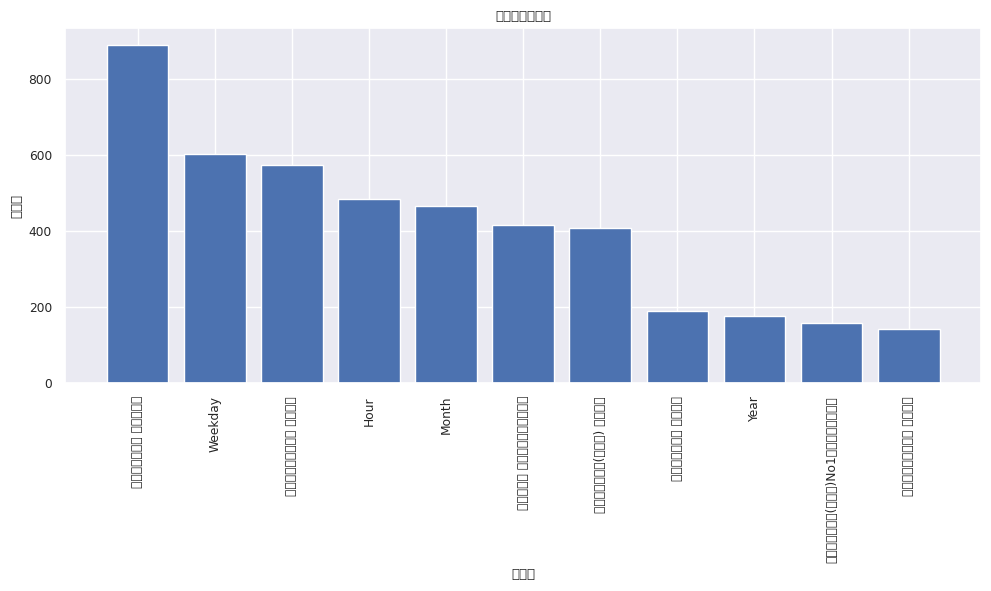

In [ ]:
if __name__ == "__main__":
    predictor = EnhancedWaterLevelPredictor(X_train_uncorrelated2, X_test_uncorrelated2, y_train, y_test)
    predictor.run_analysis(feature_selection=False, threshold_method='cumulative', threshold_value=0.9)

Epoch [10/100], Loss: 0.0026
Epoch [20/100], Loss: 0.0011
Epoch [30/100], Loss: 0.0008
Epoch [40/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0004
Epoch [60/100], Loss: 0.0006
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0002
Mean Squared Error: 0.8332739194280295
R-squared Score: -0.9960505811588451


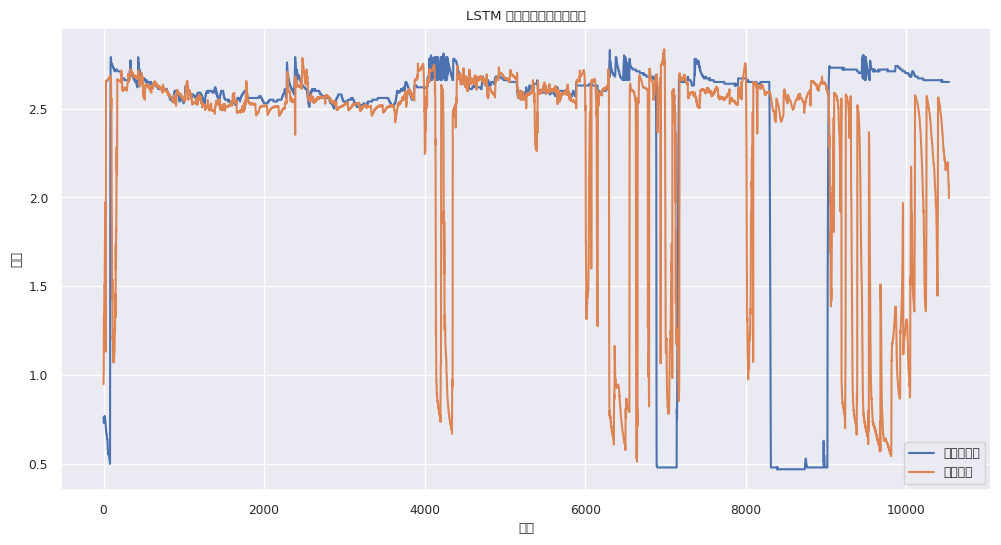

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.reshape(-1, 1))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out[:, -1, :])

class LSTMPredictor:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = None
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def handle_missing_values(self):

        df_train = pd.DataFrame(self.X_train)
        df_test = pd.DataFrame(self.X_test)


        df_train_filled = df_train.ffill()


        df_test_filled = df_test.ffill()


        df_train_filled = df_train_filled.bfill()
        df_test_filled = df_test_filled.bfill()


        self.X_train = df_train_filled.values
        self.X_test = df_test_filled.values


        self.y_train = pd.Series(self.y_train).ffill().bfill().values
        self.y_test = pd.Series(self.y_test).ffill().bfill().values

    def prepare_data(self, time_steps=10):

        self.handle_missing_values()


        self.X_train_scaled = self.scaler_X.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler_X.transform(self.X_test)


        self.y_train_scaled = self.scaler_y.fit_transform(self.y_train.reshape(-1, 1))
        self.y_test_scaled = self.scaler_y.transform(self.y_test.reshape(-1, 1))


        self.X_train_ts, self.y_train_ts = self.create_time_series(self.X_train_scaled, self.y_train_scaled, time_steps)
        self.X_test_ts, self.y_test_ts = self.create_time_series(self.X_test_scaled, self.y_test_scaled, time_steps)

    def create_time_series(self, X, y, time_steps):
        X_ts, y_ts = [], []
        for i in range(len(X) - time_steps):
            X_ts.append(X[i:(i + time_steps)])
            y_ts.append(y[i + time_steps])
        return np.array(X_ts), np.array(y_ts)

    def build_model(self, hidden_size=50, num_layers=1, dropout=0.1):
        input_size = self.X_train.shape[1]
        self.model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(self.device)

    def train_model(self, epochs=100, batch_size=32, learning_rate=0.001):
        train_dataset = TimeSeriesDataset(self.X_train_ts, self.y_train_ts)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(self.X_test_ts).to(self.device)
            y_pred_scaled = self.model(X_test_tensor).cpu().numpy()

        y_pred = self.scaler_y.inverse_transform(y_pred_scaled)
        y_true = self.scaler_y.inverse_transform(self.y_test_ts)

        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"Mean Squared Error: {mse}")
        print(f"R-squared Score: {r2}")

        return y_true, y_pred

    def plot_results(self, y_true, y_pred):
        plt.figure(figsize=(12, 6))
        plt.plot(y_true, label='実際の水位')
        plt.plot(y_pred, label='予測水位')
        plt.title('LSTM モデルによる水位予測')
        plt.xlabel('時間')
        plt.ylabel('水位')
        plt.legend()
        plt.show()

    def run_analysis(self, time_steps=10, hidden_size=50, num_layers=1, dropout=0.1, epochs=100, batch_size=32, learning_rate=0.001):
        self.prepare_data(time_steps)
        self.build_model(hidden_size, num_layers, dropout)
        self.train_model(epochs, batch_size, learning_rate)
        y_true, y_pred = self.evaluate_model()
        self.plot_results(y_true, y_pred)


if __name__ == "__main__":

    predictor = LSTMPredictor(X_train_uncorrelated, X_test_uncorrelated, y_train, y_test)
    predictor.run_analysis()

In [ ]:
ml_logger.